# Импортируем необходимые библиотеки

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
import optuna

# Загружаем набор данных
df = pd.read_csv('data/AIDS_Classification.csv')


# Шаг 1: Понимание бизнес-задачи
Цель: предсказать, заражен ли пациент СПИДом, основываясь на его медицинской и личной информации.


# Шаг 2: Понимание данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      5000 non-null   int64  
 1   trt       5000 non-null   int64  
 2   age       5000 non-null   int64  
 3   wtkg      5000 non-null   float64
 4   hemo      5000 non-null   int64  
 5   homo      5000 non-null   int64  
 6   drugs     5000 non-null   int64  
 7   karnof    5000 non-null   int64  
 8   oprior    5000 non-null   int64  
 9   z30       5000 non-null   int64  
 10  preanti   5000 non-null   int64  
 11  race      5000 non-null   int64  
 12  gender    5000 non-null   int64  
 13  str2      5000 non-null   int64  
 14  strat     5000 non-null   int64  
 15  symptom   5000 non-null   int64  
 16  treat     5000 non-null   int64  
 17  offtrt    5000 non-null   int64  
 18  cd40      5000 non-null   int64  
 19  cd420     5000 non-null   int64  
 20  cd80      5000 non-null   int6

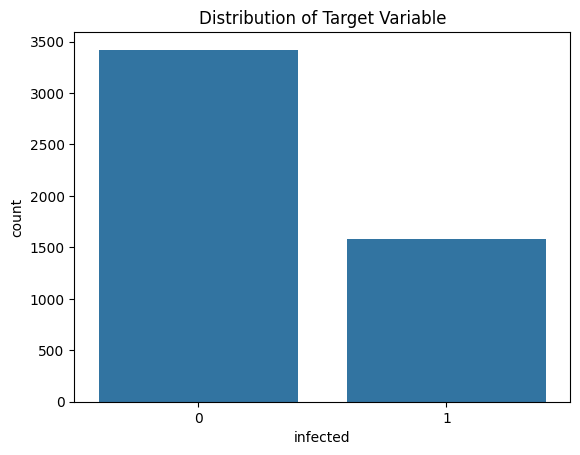

In [4]:
# Explore the dataset
df.info()
df.describe()
df.head()

# Visualize the distribution of the target variable
sns.countplot(x='infected', data=df)
plt.title('Distribution of Target Variable')
plt.show()


# Шаг 3: Подготовка данных

In [5]:
# Обработка пропущенных значений
df.isnull().sum()

# Импутация пропущенных значений (если имеются)
numeric_features = ['time', 'age', 'wtkg', 'karnof', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820']
categorical_features = ['trt', 'hemo', 'homo', 'drugs', 'oprior', 'z30', 'race', 'gender', 'str2', 'strat', 'symptom', 'treat', 'offtrt']

# Определим обработку данных для числовых признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Определим обработку данных для категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Объединим оба преобразователя в препроцессор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Handle class imbalance by resampling
df_majority = df[df.infected == 0]
df_minority = df[df.infected == 1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=42) # reproducible results

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Split data into training and testing sets
X = df_upsampled.drop('infected', axis=1)
y = df_upsampled['infected']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a pipeline that combines the preprocessor with a classifier
def create_pipeline(classifier):
    return Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', classifier)])


# Шаг 4: Моделирование

In [6]:
# Инициализация классификаторов
rf_classifier = RandomForestClassifier(random_state=42)
gb_classifier = GradientBoostingClassifier(random_state=42)

# Выполнение случайного поиска гиперпараметров
rf_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

gb_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.05],
    'classifier__max_depth': [3, 4, 5]
}

# Выполнение RandomizedSearchCV
rf_search = RandomizedSearchCV(create_pipeline(rf_classifier), rf_params, n_iter=10, cv=5, scoring='accuracy', random_state=42)
gb_search = RandomizedSearchCV(create_pipeline(gb_classifier), gb_params, n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Обучение моделей
rf_search.fit(X_train, y_train)
gb_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['time',
                                                                                'age',
                                                                                'wtkg',
                                                                                'karnof',
                                                                                'preanti',
                                                                                'cd40',
                                                                                'cd420',
                                                                                'cd80',
                                                                                'cd820']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(...re'))]),
                                                                               ['trt',
                                                                                'hemo',
                                                                                'homo',
                                                                                'drugs',
                                                                                'oprior',
                                                                                'z30',
                                                                                'race',
                                                                                'gender',
                                                                                'str2',
                                                                                'strat',
                                                                                'symptom',
                                                                                'treat',
                                                                                'offtrt'])])),
                                             ('classifier',
                                              GradientBoostingClassifier(random_state=42))]),
                   param_distributions={'classifier__learning_rate': [0.01, 0.1,
                                                                      0.05],
                                        'classifier__max_depth': [3, 4, 5],
                                        'classifier__n_estimators': [100, 200,
                                                                     300]},
                   random_state=42, scoring='accuracy')

# Шаг 5: Оценка моделей

[I 2024-05-30 05:52:15,217] A new study created in memory with name: no-name-4f8664c6-50ee-4ea2-b8a7-13979eb7625e


Отчет по RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       700
           1       0.83      0.90      0.87       669

    accuracy                           0.86      1369
   macro avg       0.86      0.86      0.86      1369
weighted avg       0.87      0.86      0.86      1369

Матрица ошибок:
[[577 123]
 [ 65 604]]
Отчет по GradientBoostingClassifier:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82       700
           1       0.80      0.87      0.83       669

    accuracy                           0.83      1369
   macro avg       0.83      0.83      0.83      1369
weighted avg       0.83      0.83      0.83      1369

Матрица ошибок:
[[552 148]
 [ 88 581]]


[I 2024-05-30 05:52:16,790] Trial 0 finished with value: 0.8210372534696859 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 159, 'rf_max_depth': 18, 'rf_min_samples_split': 10}. Best is trial 0 with value: 0.8210372534696859.
[I 2024-05-30 05:52:20,095] Trial 1 finished with value: 0.7260774287801315 and parameters: {'classifier': 'GradientBoosting', 'gb_n_estimators': 125, 'gb_learning_rate': 0.0437812545522385, 'gb_max_depth': 5}. Best is trial 0 with value: 0.8210372534696859.
[I 2024-05-30 05:52:25,576] Trial 2 finished with value: 0.6983199415631848 and parameters: {'classifier': 'GradientBoosting', 'gb_n_estimators': 271, 'gb_learning_rate': 0.020998533022155732, 'gb_max_depth': 4}. Best is trial 0 with value: 0.8210372534696859.
[I 2024-05-30 05:52:31,940] Trial 3 finished with value: 0.7348429510591673 and parameters: {'classifier': 'GradientBoosting', 'gb_n_estimators': 245, 'gb_learning_rate': 0.02599091052502881, 'gb_max_depth': 5}. Best is trial 0 with val

Best trial parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 261, 'rf_max_depth': 26, 'rf_min_samples_split': 4}
Best trial accuracy: 0.8736303871439006


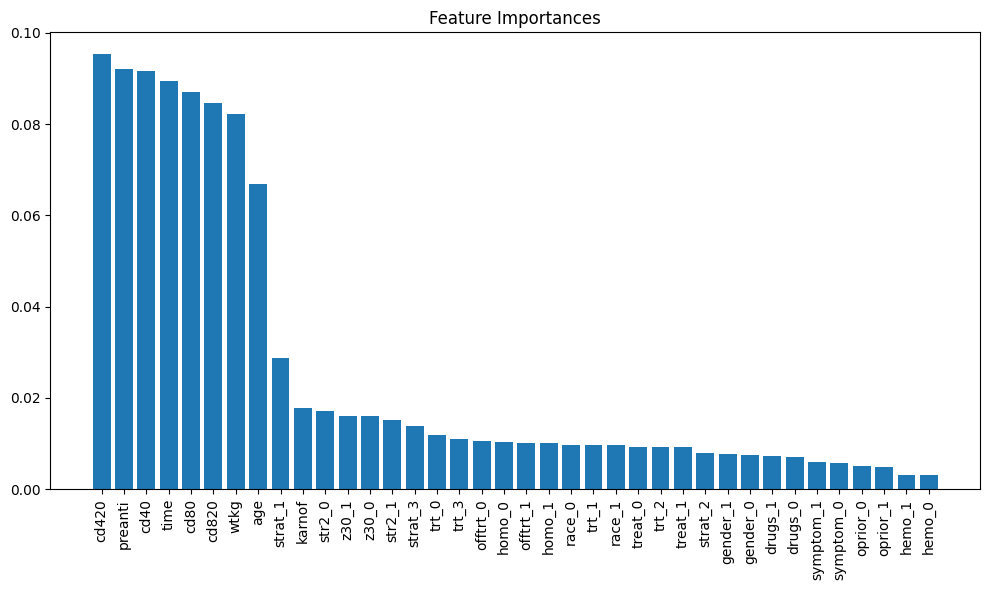

In [7]:

# Предсказание и оценка моделей
rf_predictions = rf_search.predict(X_test)
gb_predictions = gb_search.predict(X_test)

# Оценка RandomForestClassifier
print("Отчет по RandomForestClassifier:")
print(classification_report(y_test, rf_predictions))
print("Матрица ошибок:")
print(confusion_matrix(y_test, rf_predictions))

# Оценка GradientBoostingClassifier
print("Отчет по GradientBoostingClassifier:")
print(classification_report(y_test, gb_predictions))
print("Матрица ошибок:")
print(confusion_matrix(y_test, gb_predictions))

# Use Optuna for Hyperparameter Tuning
def objective(trial):
    classifier_name = trial.suggest_categorical("classifier", ["RandomForest", "GradientBoosting"])
    if classifier_name == "RandomForest":
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 100, 300)
        rf_max_depth = trial.suggest_int("rf_max_depth", 10, 30)
        rf_min_samples_split = trial.suggest_int("rf_min_samples_split", 2, 10)
        classifier_obj = RandomForestClassifier(
            n_estimators=rf_n_estimators, max_depth=rf_max_depth, min_samples_split=rf_min_samples_split, random_state=42)
    else:
        gb_n_estimators = trial.suggest_int("gb_n_estimators", 100, 300)
        gb_learning_rate = trial.suggest_float("gb_learning_rate", 0.01, 0.1)
        gb_max_depth = trial.suggest_int("gb_max_depth", 3, 5)
        classifier_obj = GradientBoostingClassifier(
            n_estimators=gb_n_estimators, learning_rate=gb_learning_rate, max_depth=gb_max_depth, random_state=42)
    
    pipeline = create_pipeline(classifier_obj)
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Get the best trial
trial = study.best_trial
print(f"Best trial parameters: {trial.params}")
print(f"Best trial accuracy: {trial.value}")

# Visualize Feature Importances for the best model
best_classifier = trial.params["classifier"]
if best_classifier == "RandomForest":
    best_rf = RandomForestClassifier(
        n_estimators=trial.params["rf_n_estimators"], 
        max_depth=trial.params["rf_max_depth"], 
        min_samples_split=trial.params["rf_min_samples_split"], 
        random_state=42)
    best_pipeline = create_pipeline(best_rf)
elif best_classifier == "GradientBoosting":
    best_gb = GradientBoostingClassifier(
        n_estimators=trial.params["gb_n_estimators"], 
        learning_rate=trial.params["gb_learning_rate"], 
        max_depth=trial.params["gb_max_depth"], 
        random_state=42)
    best_pipeline = create_pipeline(best_gb)

best_pipeline.fit(X_train, y_train)

importances = best_pipeline.named_steps['classifier'].feature_importances_
feature_names = numeric_features + list(best_pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features))

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()